<a href="https://colab.research.google.com/github/glukonatic/III/blob/master/13Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание к занятию №13 "Генерация текста". Про-задание (1)
## студента Университета искусственного интеллекта
## Наговицына Антона Михайловича
### Поток PRO НС - июль 2020 (основной тариф).
<img src="https://proza.ru/photos/glukonatic.jpg" alt="Фото Антон Наговицын" width="10%">

#Pro-1

1) Попробуйте улучшить текущий скрипт чат-бота, внедрив блок кода для присвоения словам вне словаря(out-of-vocabulary) метки “unknown” так, чтобы встретив в запросе незнакомое слово, исполнение кода не останавливалось, а продолжалось, игнорируя “unknown” слова.

2) Текущая модель не учитывает знаки препинания в диалоге. Скорректируйте некоторые блоки кода так, чтобы они учитывались. Проведите наблюдения, как добавление знаков скажется на работе и результатах сетки.


In [ ]:
#@title Импорт библиотек

import numpy as np 

import re 

from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input 
from tensorflow.keras.optimizers import RMSprop, Adadelta 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras import utils 
from tensorflow.keras.utils import plot_model 

import yaml 

In [ ]:
#@title Подключаем гуглдрайв

from google.colab import files 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Далее в одной ячейке реализован класс со всем кодом обработки данных, создания и обучения нейронки, а та же с функциями запуска чат-бота

Для решения задания 1, в коде реализовано следующее: если слова в словаре токенайзера нет, то заменяем его на самое непопулярное слово в словаре
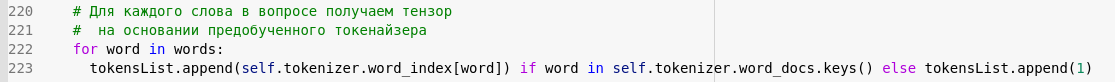

Для решения задания 2, в коде реализовано следующее:
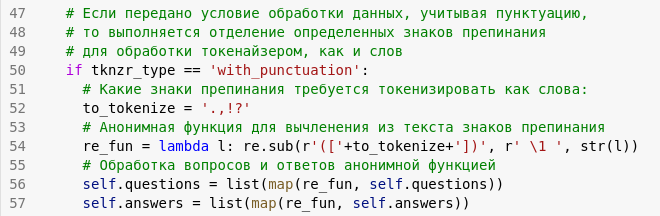

In [ ]:
#@title Класс для ДЗ

class HW13():
  """
  Класс для выполнения ДЗ-13 части PRO варианта 1
  """
  
  def __init__(self):
    """
    Инициализация класса: переменные класса
    """
    corpuspath = '/content/drive/My Drive/III/13/Диалоги(рассказы).yml'
    corpus = open(corpuspath, 'r') 
    document = yaml.safe_load(corpus)

    # Переменная для корпуса вопросов
    self.conversations = document['разговоры']
    # Список вопросов
    self.questions = list()
    # Список ответов
    self.answers = list() 
    # Результаты автоматического диалога
    self.results = list()

    print('Класс инициализирован.')


  def prepare(self, tknzr_type = 'simple'):
    """
    Подготовка данных для реализации НС чат-бота
    Функция принимает переменную tknzr_type - тип подготовки данных:
    tknzr_type = 'with_punctuation': данные обрабатываются с учетом пунктуации,
    в любом другом случае выполняется обработка данных без учета пунктуации.
    Значение переменной по умолчанию задается равным 'simple'
    """

    self.tokenizer = Tokenizer()
    # Для каждого диалога из файла
    for con in self.conversations:
      # Проверяем, является ли тип ответа строкой
      if type(con[1]) == str:
        # Добавляем вопрос
        self.questions.append(con[0]) 
        # Добавляем ответ с тегами начала и конца, и если ответов несколько - объединение
        self.answers.append('<START> ' + (' ').join(con[1:]) + ' <END>') 

    # Если передано условие обработки данных, учитывая пунктуацию,
    # то выполняется отделение определенных знаков препинания 
    # для обработки токенайзером, как и слов
    if tknzr_type == 'with_punctuation':
      # Какие знаки препинания требуется токенизировать как слова:
      to_tokenize = '.,!?'
      # Анонимная функция для вычленения из текста знаков препинания
      re_fun = lambda l: re.sub(r'(['+to_tokenize+'])', r' \1 ', str(l))
      # Обработка вопросов и ответов анонимной функцией
      self.questions = list(map(re_fun, self.questions))
      self.answers = list(map(re_fun, self.answers))

    # Обучаем токенайзер на всех вопросах и ответах
    self.tokenizer.fit_on_texts(self.questions + self.answers) 
    # Получаем словарь токенайзера
    vocabularyItems = list(self.tokenizer.word_index.items()) 
    # Определяем длину словаря токенайзера
    self.vocabularySize = len(vocabularyItems)+1 

    # Преобразуем вопросы в последовательности целых чисел
    tokenizedQuestions = self.tokenizer.texts_to_sequences(self.questions) 
    # Определяем максимальную длину вопроса
    self.maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) 
    # Приводим токенизированные вопросы к унифицированной форме:
    #  равняем длину по максимально длинному вопросу
    paddedQuestions = pad_sequences(tokenizedQuestions, 
                                    maxlen=self.maxLenQuestions, padding='post')
    # Преобразуем в numpy-массив полученные токенизированные вопросы
    #  для подачи на вход енкодера
    self.encoderForInput = np.array(paddedQuestions) 

    # Преобразуем ответы в последовательности целых чисел
    tokenizedAnswers = self.tokenizer.texts_to_sequences(self.answers) 
    # Определяем максимальную длину ответа
    self.maxLenAnswers = max([len(x) for x in tokenizedAnswers]) 
    # Приводим токенизированные ответы к унифицированной форме:
    #  равняем длину по максимально длинному ответу
    paddedAnswers = pad_sequences(tokenizedAnswers, 
                                  maxlen=self.maxLenAnswers, padding='post')
    # Преобразуем в numpy-массив полученные токенизированные ответы
    #  для подачи на вход декодера
    self.decoderForInput = np.array(paddedAnswers) 

    # Для каждого токенизированного и выровнянного по длине ответа
    #  устраняем первый тег <START>
    for i in range(len(tokenizedAnswers)) : 
      tokenizedAnswers[i] = tokenizedAnswers[i][1:] 
    # Приводим токенизированные усечённые ответы к унифицированной форме:
    #  равняем длину по максимально длинному ответу
    paddedAnswers = pad_sequences(tokenizedAnswers, 
                                  maxlen=self.maxLenAnswers , padding='post')
    # Преобразуем ответы в one-hot-тензоры
    self.oneHotAnswers = utils.to_categorical(paddedAnswers, self.vocabularySize) 
    # Преобразуем полученные one-hot-тензоры в numpy-массив
    #  для подачи на выход декодера
    self.decoderForOutput = np.array(self.oneHotAnswers) 

    print('Данные подготовлены.')
  

  def create_nn(self):
    """
    Создание нейронной сети чат-бота
    """

    # Вход энкодера
    self.encoderInputs = Input(shape=(11, )) 
    # Добавляем Embedding-слой
    encoderEmbedding = Embedding(self.vocabularySize, 
                                 200,  mask_zero=True) (self.encoderInputs)
    # Добавляем слой LSTM с возвратом состояний
    _, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
    # Получаем список состояний экнодера
    self.encoderStates = [state_h, state_c]

    # Вход декодера
    self.decoderInputs = Input(shape=(13, )) 
    # Добавляем Embedding-слой 
    self.decoderEmbedding = Embedding(self.vocabularySize, 
                                      200, mask_zero=True) (self.decoderInputs) 
    # Добавляем слой LSTM с возвратом состояний
    self.decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
    # Получаем выход LSTM-слоя, без сохранения состояний
    decoderOutputs , _ , _ = self.decoderLSTM (self.decoderEmbedding, 
                                               initial_state=self.encoderStates)
    # Добавляем полносвязный слой с активацией softmax
    self.decoderDense = Dense(self.vocabularySize, activation='softmax') 
    # Получаем выход декодера
    output = self.decoderDense(decoderOutputs)

    # Объявляем модель НС чат-бота
    self.model = Model([self.encoderInputs, self.decoderInputs], output)
    # Компилируем её
    self.model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

    print('Модель скомпилирована.')
    

  def fit(self, bs=50, ep=10, v=0):
    """
    Обучение нейронной сети
    """

    print('Запуск обучения...') 
    # Непосредственно запуск обучения
    self.model.fit([self.encoderForInput , self.decoderForInput], 
                   self.decoderForOutput, 
                   batch_size=bs, epochs=ep, verbose = v) 
    
    print('...Цикл обучения завершен')


  def makeInferenceModels(self):
    """
    Определение интерференции новой фразы (новый диалог) и 
      предобученной модели.
    В функции объявляются модели энкодера и декодера
      для кодирования входной фразы и раскодирования ответа на нее
      на основании состояний имеющейся предобученной модели чат-бота
    Возвращает модель энкодера и декодера
    """

    # Объявляем модель энкодера для диалога,
    #  указываем на входе Input энкодера 
    #  и тензоры состояния на входе обученной модели
    encoderModel = Model(self.encoderInputs, self.encoderStates) 

    # Объявляем входы декодера
    decoderStateInput_h = Input(shape=(200 ,)) 
    decoderStateInput_c = Input(shape=(200 ,))
    
    # Описываем переменную, которая будет частью входа декодера
    decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] 

    # Определяем выходы декодера как состояние узлов LSTM-слоя,
    #  описанной для модели чат-бота ранее, 
    #  при передаче той же матрицы, что и при объявлении обученной модели НС,
    #  при этом инициализируем исходное состояние тензорами текущего входа (фразы)
    decoderOutputs, state_h, state_c = self.decoderLSTM(self.decoderEmbedding, 
                                                        initial_state=decoderStatesInputs)

    # Описываем переменную, хранящую состояние на выходе LSTM-слоя выше
    decoderStates = [state_h, state_c] 

    # Получаем выход для передачи в модель декодера
    decoderOutputs = self.decoderDense(decoderOutputs) 
    
    # Объявляем модель декодера для диалога
    #  на входе сумма тензоров входа обученной модели с тензорами текущего входа (диалога),
    #  а так же выход, полученный в результате обработки LSTM-слоя объявленной модели
    #  при инициализации исходного состояния тензорами текущего входа (фразы)
    #  в сумме с состоянием LSTM-модели после подачи диалоговой фразы
    decoderModel = Model([self.decoderInputs] + decoderStatesInputs, 
                         [decoderOutputs] + decoderStates)

    # Возвращаем модель энкодера и декодера
    return encoderModel , decoderModel


  def strToTokens(self, sentence: str): 
    """
    Преобразование строки в токен на основании предобученного токенайзера
    Входная строка преобразуется в нижний регистр,
      и для каждого слова получаем токенизированный тензор,
      который так же приводится к унифицированной длине (максимальная длина вопроса)
    Возвращает предопределенной величины токенизированный тензор вопроса
    """

    # Строка преобразуется в нижний регистр
    words = sentence.lower().split() 
    # Объявляется список результирующих тензоров
    tokensList = list() 

    # Для каждого слова в вопросе получаем тензор 
    #  на основании предобученного токенайзера
    for word in words: 
      tokensList.append(self.tokenizer.word_index[word]) if word in self.tokenizer.word_docs.keys() else tokensList.append(1) 

    # Возвращаем тензоры слов вопроса универсальной длины
    return pad_sequences([tokensList], maxlen=self.maxLenQuestions , padding='post')


  def main(self, dialog_type = 'manual', phrases = 6):
    """
    Главная функция для запуска чат-бота
    """

    # Берем описанные модели энкодера и декодера для запуска чат-бота
    encModel, decModel = self.makeInferenceModels() 

    # Фразы для автоматического прогона чат-бота
    self.auto_phrases = ['Привет','Как дела','Почему так','Ты вообще кто','А если найду','Ужас какой']

    # Начинаем диалог
    for i in range(phrases): 

      # Режим общения: автоматический или общение с оператором (пользователем)
      #  В случае автоматического - передаем заготовленные фразы по циклу,
      #  а при общении с пользователем - приглашаем ввести вопрос в консоли
      if dialog_type == 'auto':
        statesValues = encModel.predict(self.strToTokens(self.auto_phrases[i]))
      else:
        statesValues = encModel.predict(self.strToTokens(input( 'Задайте вопрос : ' )))

      # Объявляем матрицу (1,1) и записываем в ячейку (0,0) индекс тега 'start'
      emptyTargetSeq = np.zeros((1, 1))    
      emptyTargetSeq[0, 0] = self.tokenizer.word_index['start'] 

      # Инициализируем условие остановки цикла определения ответа
      stopCondition = False 

      # Декодированный ответ чат-бота
      decodedTranslation = '' 

      # Бесконечный цикл, пока не заявлено стоп-условие
      while not stopCondition : 
        
        # Моделью декодера предсказываем ответ (по-словно),
        #  получаем тензор-ответ и состояние модели бота при получении фразы
        decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)

        # Берем индекс наиболее вероятного слова, которое спредиктил декодер
        sampledWordIndex = np.argmax(decOutputs, axis=-1) 

        # Получаем само слово из его индекса
        sampledWord = None 
        for word , index in self.tokenizer.word_index.items():
          if sampledWordIndex == index: 
            decodedTranslation += ' {}'.format(word) 
            sampledWord = word 

        # Если встретили стоп-слово 
        #  или сгенерированный ответ больше максимальной длины ответов,
        #  то останавливаем бесконечный цикл, установкой стоп-условия
        if sampledWord == 'end' or len(decodedTranslation.split()) > self.maxLenAnswers:
          stopCondition = True 

        # Объявляем матрицу (1,1) и записываем в ячейку (0,0) 
        #  индекс текущего слова ответа
        emptyTargetSeq = np.zeros((1, 1)) 
        emptyTargetSeq[0, 0] = sampledWordIndex 

        # Запоминаем текущее состояние модели бота
        statesValues = [h, c] 

      # Если режим общения автоматический, то заполняем список результатов
      if dialog_type == 'auto':
        self.results.append(decodedTranslation[:-3]) 
      else:
        print(decodedTranslation[:-3]) 


  def clear_vars(self):
    """
    Очистка памяти виртуального окружения от переменных класса
    """

    # self.questions.clear()
    # self.answers.clear()
    # del self.tokenizer
    # del self.vocabularySize
    # del self.maxLenQuestions
    # del self.encoderForInput
    # del self.maxLenAnswers
    # del self.decoderForInput
    del self.oneHotAnswers
    del self.decoderForOutput

    print('Переменные удалены и очищены')

In [ ]:
#@title Инициализация объекта класса
#@markdown Подготовка данных, создание нейронной сети, обучение
#@markdown Запуск двух нейронок: с учетом пунктуации и без учета пунктуации

#@markdown Количество циклов обучения по 10 эпох:
cycles =  10#@param {type: "number"}

first = HW13()

first.prepare('with_punctuation')
first.create_nn()

for i in range(cycles):
  first.fit()
  first.main('auto')

first.clear_vars()

second = HW13()

second.prepare()
second.create_nn()

for i in range(cycles):
  second.fit()
  second.main('auto')

second.clear_vars()

Класс инициализирован.
Данные подготовлены.
Модель скомпилирована.
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Переменные удалены и очищены
Класс инициализирован.
Данные подготовлены.
Модель скомпилирована.
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл обучения завершен
Запуск обучения...
...Цикл 

In [ ]:
#@title Вывод диалогов обоих ботов
#@markdown Первый бот - С учетом пунктуации, второй бот - БЕЗ учета пунктуации

for i in range(cycles):
  print('{}-й цикл обучения:'.format(i+1))
  for phrase in first.auto_phrases:
    print("\tВопрос:",phrase)
    print("Первый бот:",first.results[i*len(first.auto_phrases) + first.auto_phrases.index(phrase)])
    print("Второй бот:",second.results[i*len(second.auto_phrases) + second.auto_phrases.index(phrase)])    
    print('\n')
  print('\n')

1-й цикл обучения:
	Вопрос: Привет
Первый бот:  ну что 
Второй бот:  ну что ты 


	Вопрос: Как дела
Первый бот:  я не знаю 
Второй бот:  да 


	Вопрос: Почему так
Первый бот:  ничего 
Второй бот:  ничего 


	Вопрос: Ты вообще кто
Первый бот:  да нет 
Второй бот:  нет нет 


	Вопрос: А если найду
Первый бот:  не знаю 
Второй бот:  да 


	Вопрос: Ужас какой
Первый бот:  да 
Второй бот:  не знаю 




2-й цикл обучения:
	Вопрос: Привет
Первый бот:  ну так и и дело 
Второй бот:  что вы с тобой в этом чем я 


	Вопрос: Как дела
Первый бот:  да 
Второй бот:  все в порядке 


	Вопрос: Почему так
Первый бот:  ничего 
Второй бот:  не знаю 


	Вопрос: Ты вообще кто
Первый бот:  я я об этом не знаю 
Второй бот:  я я хочу тебя а я а кто то кто 


	Вопрос: А если найду
Первый бот:  ты знаешь почему ты 
Второй бот:  как мной 


	Вопрос: Ужас какой
Первый бот:  на каком 
Второй бот:  на каком 




3-й цикл обучения:
	Вопрос: Привет
Первый бот:  что вы знаете 
Второй бот:  что нибудь 


	Вопрос: Как де